<a href="https://colab.research.google.com/github/Seemab22/ThesisActivity/blob/main/New_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time, copy, math, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# ----------------------------- CONFIG ------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
frame_size = 100
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'left angular X[dps]',
    'left angular Y[dps]',
    'left angular Z[dps]',
]
label_map = {'HES': 0, 'HER': 1, 'TOF': 2, 'FOF': 3}

# -------------------------- DATA AUGMENTATION -----------------------------
def augment_segment(segment: np.ndarray) -> np.ndarray:
    noise = np.random.normal(0, 0.01, segment.shape)
    scale = np.random.uniform(0.9, 1.1)
    shift = np.random.randint(-5, 5)
    segment_aug = (segment + noise) * scale
    return np.roll(segment_aug, shift, axis=0)

def balance_with_augmentation(frames: np.ndarray, labels: np.ndarray, target_count: int | None = None):
    frames_balanced = []
    labels_balanced = []
    counts = Counter(labels)
    if target_count is None:
        target_count = max(counts.values())
    for class_idx in range(len(label_map)):
        class_frames = frames[labels == class_idx]
        n_samples = len(class_frames)
        frames_balanced.extend(class_frames)
        labels_balanced.extend([class_idx] * n_samples)
        if n_samples < target_count:
            n_to_add = target_count - n_samples
            for _ in range(n_to_add):
                frame = class_frames[np.random.randint(0, n_samples)]
                frame_reshaped = frame.reshape(frame_size, len(feature_cols))
                aug_frame = augment_segment(frame_reshaped).flatten()
                frames_balanced.append(aug_frame)
                labels_balanced.append(class_idx)
    return np.array(frames_balanced), np.array(labels_balanced)

# ------------------------------ DATASET ----------------------------------
class IMUDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32).reshape(-1, frame_size, len(feature_cols))
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx: int):
        return self.X[idx], self.Y[idx]

# -------------------------- DATA PROCESSING ------------------------------
def process_file(filepath: str):
    df = pd.read_excel(filepath)
    df = df.dropna(subset=feature_cols + ['Event- Label level 2- Left Foot'])
    df['label'] = df['Event- Label level 2- Left Foot'].map(label_map)
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)
    frames, labels = [], []
    for i in range(0, len(df) - frame_size + 1, frame_size):
        segment = df.iloc[i:i + frame_size]
        label = np.bincount(segment['label']).argmax()
        frames.append(segment[feature_cols].values.flatten())
        labels.append(label)
    return frames, labels

def load_all_group_data(root_dir: str, groups: list[str]):
    all_frames, all_labels = [], []
    print("\nLoading data...")
    for group in groups:
        group_path = os.path.join(root_dir, group)
        for file in os.listdir(group_path):
            if file.endswith('.xlsx'):
                try:
                    frames, labels = process_file(os.path.join(group_path, file))
                    all_frames += list(frames)
                    all_labels += list(labels)
                except KeyError as e:
                    print(f"File skipped due to missing columns: {file}")
                    print(f"Missing columns error: {e}")
    all_frames = np.array(all_frames)
    all_labels = np.array(all_labels)
    print("Loaded:", all_frames.shape, "Labels:", Counter(all_labels))
    counts = Counter(all_labels)
    plt.figure(figsize=(6, 4))
    plt.bar([list(label_map.keys())[i] for i in counts.keys()], counts.values(), color='skyblue')
    plt.title('Class Distribution After Loading Data')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.show()
    return all_frames, all_labels

# --------------------------- MODEL COMPONENTS ----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_head: int, drop: float = 0.1):
        super().__init__()
        self.n_head = n_head
        self.d_head = d_model // n_head
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()
        qkv = self.qkv(x).reshape(B, T, 3, self.n_head, self.d_head).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)
        attn = attn.softmax(dim=-1)
        out = torch.matmul(attn, v).transpose(1, 2).reshape(B, T, C)
        out = self.out(out)
        return self.drop(out)

class FeedForward(nn.Module):
    def __init__(self, d_model: int, hidden: int, drop: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, d_model)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, n_head: int, hidden: int, drop: float = 0.3):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head, drop)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, hidden, drop)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.norm1(x + self.drop(self.attn(x)))
        x = self.norm2(x + self.drop(self.ff(x)))
        return x

class TransformerModel(nn.Module):
    def __init__(self, d_model: int = 128, n_head: int = 8, n_layers: int = 3,
                 hidden: int = 256, n_classes: int = 4, seq_len: int = 100,
                 drop: float = 0.1):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(6, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(drop)
        )
        self.pos = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, hidden, drop=drop) for _ in range(n_layers)
        ])
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(d_model * seq_len, 256),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(256, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        x = self.pos(x)
        for layer in self.layers:
            x = layer(x)
        return self.head(x)

class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor | None = None, gamma: int = 2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=alpha)

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

# --------------------------- TRAINING UTILS ------------------------------
def train_one_epoch(model: nn.Module, loader: DataLoader, opt: torch.optim.Optimizer,
                    scaler: GradScaler, loss_fn: nn.Module):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        with autocast():
            out = model(x)
            loss = loss_fn(out, y)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

def validate(model: nn.Module, loader: DataLoader, loss_fn: nn.Module):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    return total_loss / total, correct / total, preds, labels

# ----------------------------- TRAINING ----------------------------------
def cross_validate(frames: np.ndarray, labels: np.ndarray, root_dir: str, *,
                   k: int = 5, epochs: int = 50, batch_size: int = 32, lr: float = 1e-4,
                   patience: int = 10, use_augmentation: bool = True):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    results = []
    scaler = StandardScaler()
    frames = scaler.fit_transform(frames)
    weights = compute_class_weight('balanced', classes=np.arange(len(label_map)), y=labels)
    alpha = torch.tensor(weights, dtype=torch.float32).to(device)

    for fold, (tr_idx, va_idx) in enumerate(skf.split(frames, labels), 1):
        print(f"\n===== Fold {fold}/{k} =====")
        Xtr, Ytr = frames[tr_idx], labels[tr_idx]
        Xva, Yva = frames[va_idx], labels[va_idx]

        ros = RandomOverSampler()
        Xtr, Ytr = ros.fit_resample(Xtr, Ytr)
        if use_augmentation:
            Xtr, Ytr = balance_with_augmentation(Xtr, Ytr, target_count=None)
        print("Training samples after balancing:", Counter(Ytr))

        train_loader = DataLoader(IMUDataset(Xtr, Ytr), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(IMUDataset(Xva, Yva), batch_size=batch_size)

        model = TransformerModel().to(device)
        opt = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3, verbose=True)
        loss_fn = FocalLoss(alpha)
        amp_scaler = GradScaler()

        best_acc = 0.0
        best_wts = copy.deepcopy(model.state_dict())
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        no_improve = 0

        for ep in range(epochs):
            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, amp_scaler, loss_fn)
            va_loss, va_acc, preds, labs = validate(model, val_loader, loss_fn)
            scheduler.step(va_loss)
            history["train_loss"].append(tr_loss)
            history["val_loss"].append(va_loss)
            history["train_acc"].append(tr_acc)
            history["val_acc"].append(va_acc)
            print(f"Epoch {ep+1}: Train Acc={tr_acc:.3f} | Val Acc={va_acc:.3f} | Val Loss={va_loss:.4f}")
            if va_acc > best_acc:
                best_acc = va_acc
                best_wts = copy.deepcopy(model.state_dict())
                no_improve = 0
            else:
                no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered")
                break

        epochs_range = range(1, len(history["train_loss"]) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history["train_loss"], label="Train Loss")
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
        plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title(f"Fold {fold} Loss")
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, history["train_acc"], label="Train Acc")
        plt.plot(epochs_range, history["val_acc"], label="Val Acc")
        plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"Fold {fold} Accuracy")
        plt.show()

        model.load_state_dict(best_wts)
        va_loss, va_acc, preds, labs = validate(model, val_loader, loss_fn)
        acc = accuracy_score(labs, preds)
        prec = precision_score(labs, preds, average='weighted')
        rec = recall_score(labs, preds, average='weighted')
        f1 = f1_score(labs, preds, average='weighted')
        print(f"Fold {fold} Final: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f}")

        torch.save(model.state_dict(), os.path.join(root_dir, f"transformer_fold{fold}.pth"))
        cm = confusion_matrix(labs, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
        plt.title(f"Confusion Matrix Fold {fold}")
        plt.show()

        results.append({'fold': fold, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1})

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(root_dir, "cv_metrics.csv"), index=False)
    print("\nAverage:", df[['acc', 'prec', 'rec', 'f1']].mean())
    return df


Loading data...
File skipped due to missing columns: pd004_1norm2.xlsx
Missing columns error: ['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]']
Loaded: (3112, 600) Labels: Counter({np.int64(2): 1477, np.int64(3): 912, np.int64(0): 568, np.int64(1): 155})


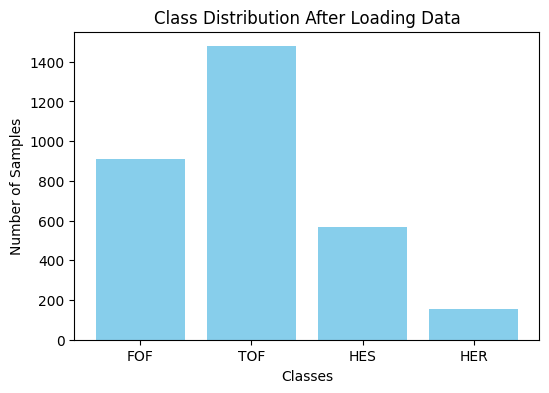

In [3]:
# ==================== USAGE =============================
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['PD','EL']
frames,labels=load_all_group_data(root_dir,groups)


===== Fold 1/5 =====
Training samples after balancing: Counter({np.int64(0): 1182, np.int64(1): 1182, np.int64(2): 1182, np.int64(3): 1182})


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-3731403241.py:263: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler = GradScaler()
/tmp/ipython-input-3731403241.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.406 | Val Acc=0.371 | Val Loss=0.7671
Epoch 2: Train Acc=0.552 | Val Acc=0.525 | Val Loss=0.5507
Epoch 3: Train Acc=0.617 | Val Acc=0.390 | Val Loss=0.7021
Epoch 4: Train Acc=0.649 | Val Acc=0.578 | Val Loss=0.5127
Epoch 5: Train Acc=0.691 | Val Acc=0.552 | Val Loss=0.5887
Epoch 6: Train Acc=0.724 | Val Acc=0.570 | Val Loss=0.5429
Epoch 7: Train Acc=0.739 | Val Acc=0.559 | Val Loss=0.6540
Epoch 8: Train Acc=0.768 | Val Acc=0.560 | Val Loss=0.5815
Epoch 9: Train Acc=0.796 | Val Acc=0.570 | Val Loss=0.6033
Epoch 10: Train Acc=0.805 | Val Acc=0.579 | Val Loss=0.6096
Epoch 11: Train Acc=0.797 | Val Acc=0.597 | Val Loss=0.6317
Epoch 12: Train Acc=0.808 | Val Acc=0.586 | Val Loss=0.6399
Epoch 13: Train Acc=0.822 | Val Acc=0.591 | Val Loss=0.6833
Epoch 14: Train Acc=0.823 | Val Acc=0.613 | Val Loss=0.6287
Epoch 15: Train Acc=0.829 | Val Acc=0.589 | Val Loss=0.6445
Epoch 16: Train Acc=0.832 | Val Acc=0.604 | Val Loss=0.6414
Epoch 17: Train Acc=0.847 | Val Acc=0.612 | Val L

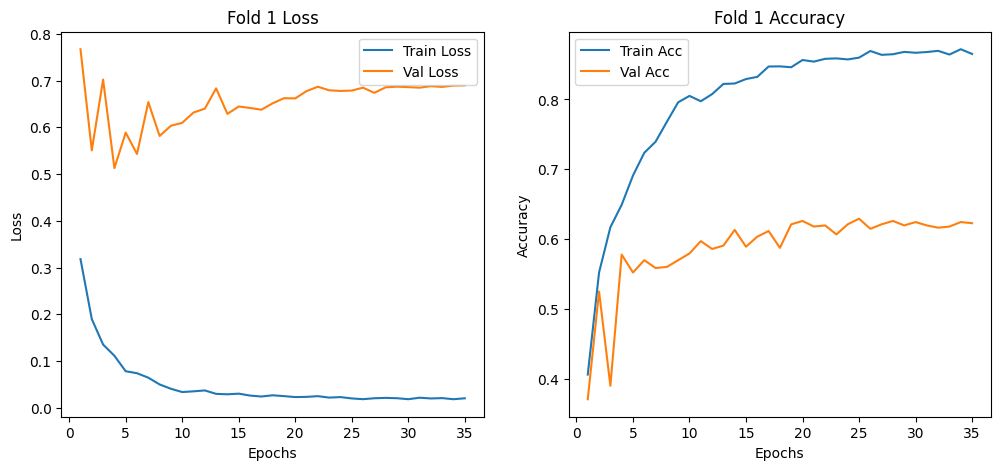

Fold 1 Final: Acc=0.629 Prec=0.670 Rec=0.629 F1=0.644


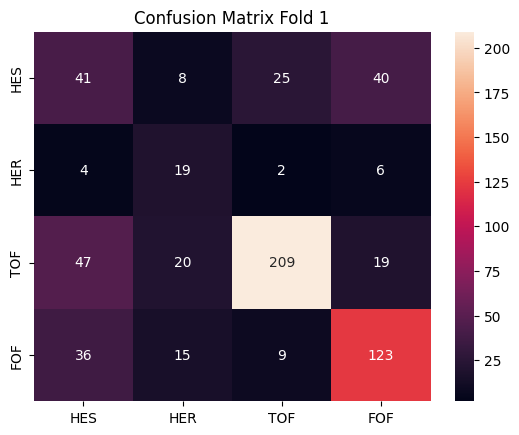


===== Fold 2/5 =====
Training samples after balancing: Counter({np.int64(0): 1182, np.int64(1): 1182, np.int64(2): 1182, np.int64(3): 1182})


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-3731403241.py:263: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler = GradScaler()
/tmp/ipython-input-3731403241.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.382 | Val Acc=0.376 | Val Loss=0.6886
Epoch 2: Train Acc=0.522 | Val Acc=0.340 | Val Loss=0.8894
Epoch 3: Train Acc=0.591 | Val Acc=0.626 | Val Loss=0.5538
Epoch 4: Train Acc=0.652 | Val Acc=0.467 | Val Loss=0.7591
Epoch 5: Train Acc=0.675 | Val Acc=0.587 | Val Loss=0.6040
Epoch 6: Train Acc=0.707 | Val Acc=0.578 | Val Loss=0.7076
Epoch 7: Train Acc=0.736 | Val Acc=0.589 | Val Loss=0.7546
Epoch 8: Train Acc=0.760 | Val Acc=0.632 | Val Loss=0.6898
Epoch 9: Train Acc=0.788 | Val Acc=0.589 | Val Loss=0.6907
Epoch 10: Train Acc=0.798 | Val Acc=0.616 | Val Loss=0.7287
Epoch 11: Train Acc=0.793 | Val Acc=0.583 | Val Loss=0.8010
Epoch 12: Train Acc=0.804 | Val Acc=0.604 | Val Loss=0.7514
Epoch 13: Train Acc=0.824 | Val Acc=0.607 | Val Loss=0.7825
Epoch 14: Train Acc=0.828 | Val Acc=0.557 | Val Loss=0.7893
Epoch 15: Train Acc=0.830 | Val Acc=0.620 | Val Loss=0.7601
Epoch 16: Train Acc=0.838 | Val Acc=0.620 | Val Loss=0.7859
Epoch 17: Train Acc=0.838 | Val Acc=0.640 | Val L

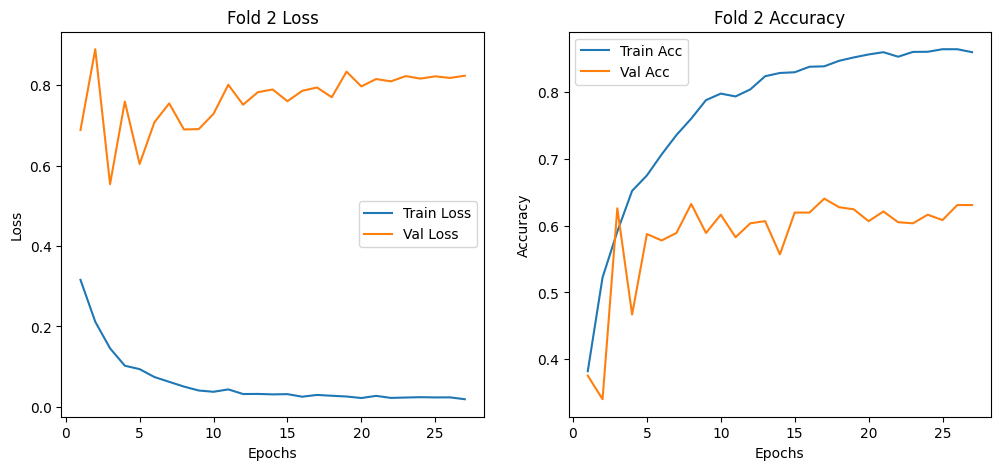

Fold 2 Final: Acc=0.640 Prec=0.679 Rec=0.640 F1=0.655


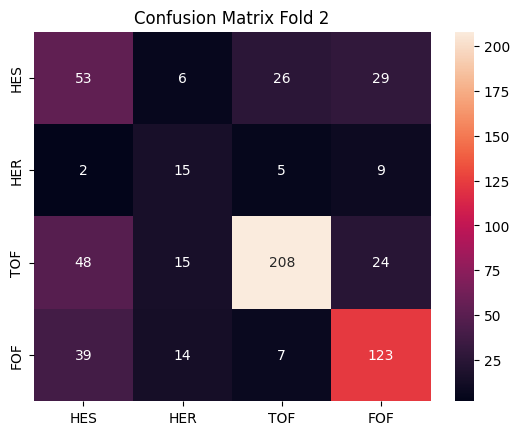


===== Fold 3/5 =====
Training samples after balancing: Counter({np.int64(0): 1181, np.int64(1): 1181, np.int64(2): 1181, np.int64(3): 1181})


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-3731403241.py:263: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler = GradScaler()
/tmp/ipython-input-3731403241.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.378 | Val Acc=0.246 | Val Loss=0.9475
Epoch 2: Train Acc=0.538 | Val Acc=0.418 | Val Loss=0.7408
Epoch 3: Train Acc=0.598 | Val Acc=0.350 | Val Loss=0.9016
Epoch 4: Train Acc=0.635 | Val Acc=0.466 | Val Loss=0.6614
Epoch 5: Train Acc=0.661 | Val Acc=0.450 | Val Loss=0.7409
Epoch 6: Train Acc=0.691 | Val Acc=0.606 | Val Loss=0.6490
Epoch 7: Train Acc=0.713 | Val Acc=0.585 | Val Loss=0.6171
Epoch 8: Train Acc=0.741 | Val Acc=0.543 | Val Loss=0.7211
Epoch 9: Train Acc=0.766 | Val Acc=0.486 | Val Loss=0.7846
Epoch 10: Train Acc=0.765 | Val Acc=0.555 | Val Loss=0.7573
Epoch 11: Train Acc=0.792 | Val Acc=0.633 | Val Loss=0.7851
Epoch 12: Train Acc=0.820 | Val Acc=0.608 | Val Loss=0.7147
Epoch 13: Train Acc=0.829 | Val Acc=0.630 | Val Loss=0.7738
Epoch 14: Train Acc=0.842 | Val Acc=0.585 | Val Loss=0.7495
Epoch 15: Train Acc=0.843 | Val Acc=0.635 | Val Loss=0.8286
Epoch 16: Train Acc=0.856 | Val Acc=0.633 | Val Loss=0.8048
Epoch 17: Train Acc=0.858 | Val Acc=0.611 | Val L

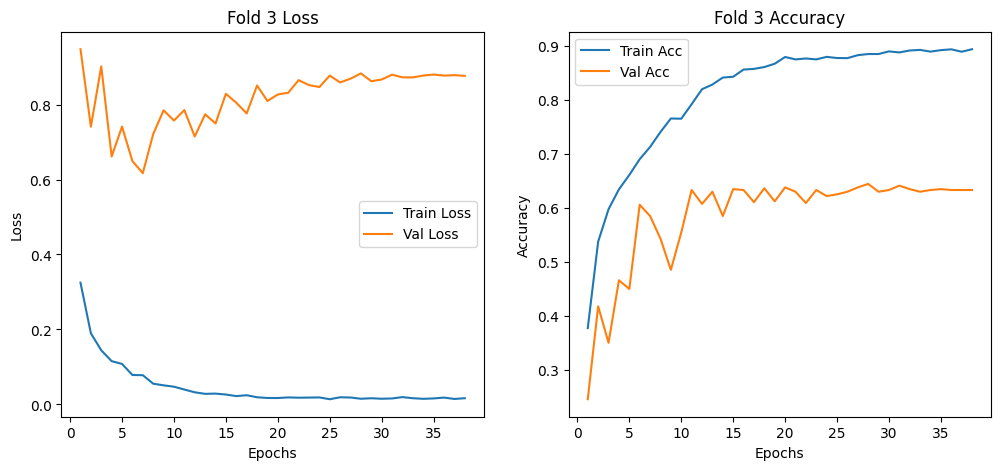

Fold 3 Final: Acc=0.645 Prec=0.662 Rec=0.645 F1=0.652


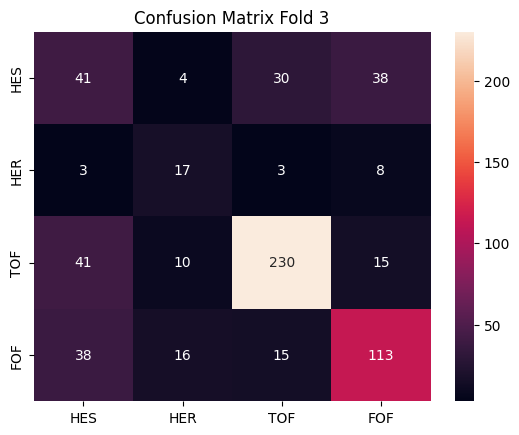


===== Fold 4/5 =====
Training samples after balancing: Counter({np.int64(0): 1181, np.int64(1): 1181, np.int64(2): 1181, np.int64(3): 1181})


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-3731403241.py:263: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler = GradScaler()
/tmp/ipython-input-3731403241.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.393 | Val Acc=0.217 | Val Loss=1.1152
Epoch 2: Train Acc=0.535 | Val Acc=0.352 | Val Loss=0.8819
Epoch 3: Train Acc=0.588 | Val Acc=0.314 | Val Loss=0.9270
Epoch 4: Train Acc=0.636 | Val Acc=0.405 | Val Loss=0.8631
Epoch 5: Train Acc=0.662 | Val Acc=0.452 | Val Loss=0.7174
Epoch 6: Train Acc=0.699 | Val Acc=0.542 | Val Loss=0.6071
Epoch 7: Train Acc=0.735 | Val Acc=0.490 | Val Loss=0.7553
Epoch 8: Train Acc=0.759 | Val Acc=0.629 | Val Loss=0.6850
Epoch 9: Train Acc=0.781 | Val Acc=0.516 | Val Loss=0.8690
Epoch 10: Train Acc=0.795 | Val Acc=0.600 | Val Loss=0.8502
Epoch 11: Train Acc=0.831 | Val Acc=0.582 | Val Loss=0.9418
Epoch 12: Train Acc=0.845 | Val Acc=0.627 | Val Loss=0.8584
Epoch 13: Train Acc=0.846 | Val Acc=0.606 | Val Loss=0.9545
Epoch 14: Train Acc=0.852 | Val Acc=0.658 | Val Loss=0.9359
Epoch 15: Train Acc=0.865 | Val Acc=0.603 | Val Loss=0.9204
Epoch 16: Train Acc=0.864 | Val Acc=0.606 | Val Loss=0.9320
Epoch 17: Train Acc=0.873 | Val Acc=0.616 | Val L

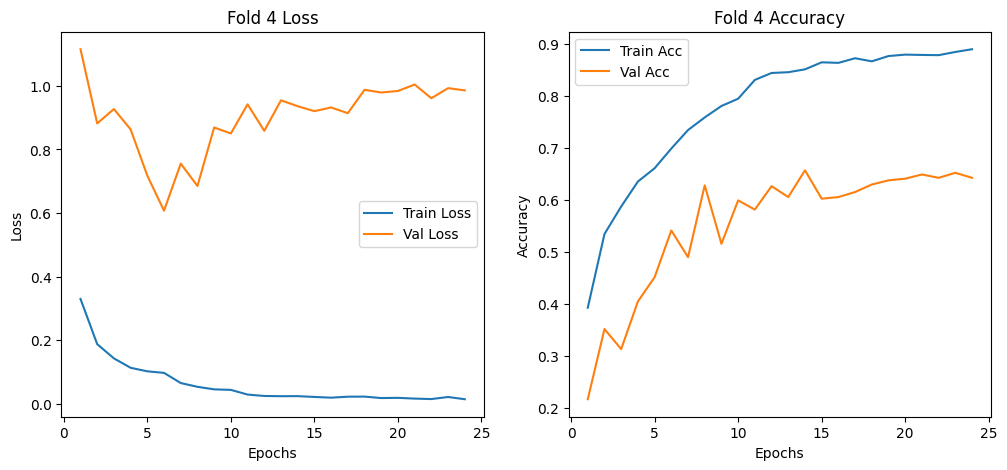

Fold 4 Final: Acc=0.658 Prec=0.679 Rec=0.658 F1=0.665


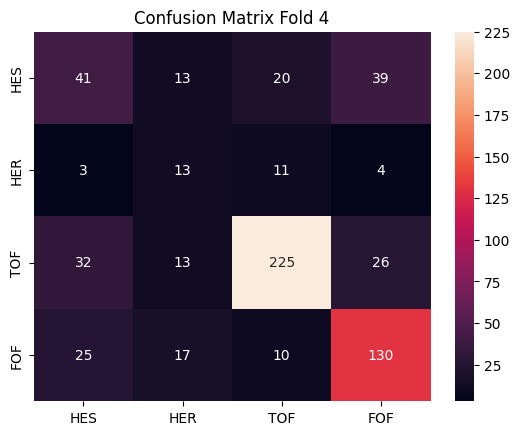


===== Fold 5/5 =====
Training samples after balancing: Counter({np.int64(0): 1182, np.int64(1): 1182, np.int64(2): 1182, np.int64(3): 1182})


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-3731403241.py:263: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  amp_scaler = GradScaler()
/tmp/ipython-input-3731403241.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Acc=0.391 | Val Acc=0.421 | Val Loss=0.6310
Epoch 2: Train Acc=0.528 | Val Acc=0.397 | Val Loss=0.6227
Epoch 3: Train Acc=0.585 | Val Acc=0.432 | Val Loss=0.6041
Epoch 4: Train Acc=0.618 | Val Acc=0.431 | Val Loss=0.7253
Epoch 5: Train Acc=0.646 | Val Acc=0.598 | Val Loss=0.5586
Epoch 6: Train Acc=0.667 | Val Acc=0.503 | Val Loss=0.8645
Epoch 7: Train Acc=0.708 | Val Acc=0.457 | Val Loss=0.6600
Epoch 8: Train Acc=0.733 | Val Acc=0.585 | Val Loss=0.7806
Epoch 9: Train Acc=0.755 | Val Acc=0.563 | Val Loss=0.8494
Epoch 10: Train Acc=0.790 | Val Acc=0.654 | Val Loss=0.7744
Epoch 11: Train Acc=0.806 | Val Acc=0.616 | Val Loss=0.7848
Epoch 12: Train Acc=0.815 | Val Acc=0.638 | Val Loss=0.7687
Epoch 13: Train Acc=0.822 | Val Acc=0.577 | Val Loss=0.7872
Epoch 14: Train Acc=0.834 | Val Acc=0.645 | Val Loss=0.7464
Epoch 15: Train Acc=0.839 | Val Acc=0.605 | Val Loss=0.8092
Epoch 16: Train Acc=0.843 | Val Acc=0.629 | Val Loss=0.7489
Epoch 17: Train Acc=0.850 | Val Acc=0.643 | Val L

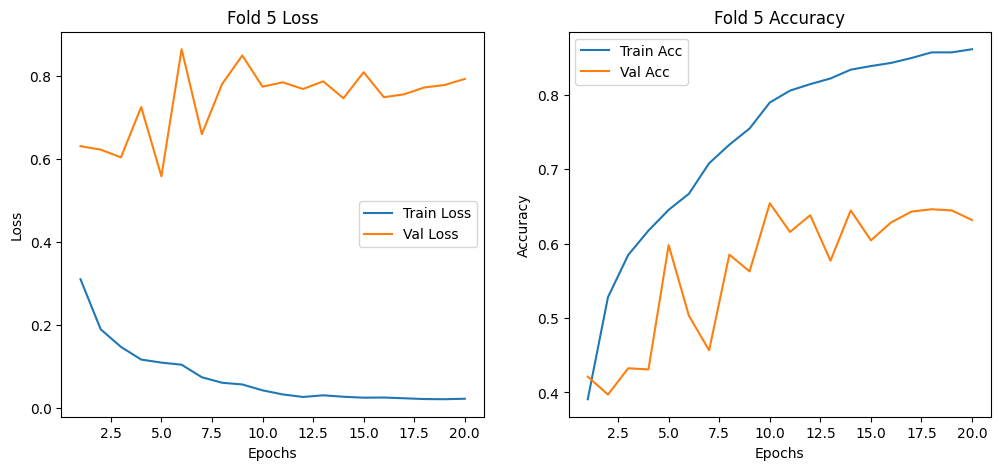

Fold 5 Final: Acc=0.654 Prec=0.681 Rec=0.654 F1=0.665


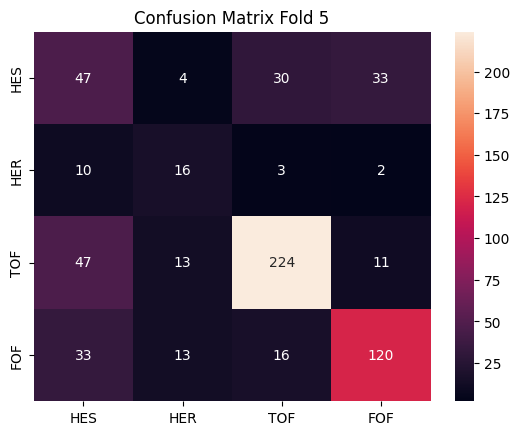


Average: acc     0.645251
prec    0.674217
rec     0.645251
f1      0.656147
dtype: float64


,fold,acc,prec,rec,f1
0,1,0.629213,0.669980,0.629213,0.643642
1,2,0.640449,0.678893,0.640449,0.654663
2,3,0.644695,0.662326,0.644695,0.651973
3,4,0.657556,0.679000,0.657556,0.665231
4,5,0.654341,0.680884,0.654341,0.665225


In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
cross_validate(frames,labels,'/content/drive/MyDrive/IMU/kFold_Results_ActivityRecog_new',k=5,epochs=200,batch_size=16,lr=5e-5)